# Stock Price Prediction Using RNNs

## Objective
The objective of this assignment is to try and predict the stock prices using historical data from four companies IBM (IBM), Google (GOOGL), Amazon (AMZN), and Microsoft (MSFT).

We use four different companies because they belong to the same sector: Technology. Using data from all four companies may improve the performance of the model. This way, we can capture the broader market sentiment.

The problem statement for this assignment can be summarised as follows:

> Given the stock prices of Amazon, Google, IBM, and Microsoft for a set number of days, predict the stock price of these companies after that window.

## Business Value

Data related to stock markets lends itself well to modeling using RNNs due to its sequential nature. We can keep track of opening prices, closing prices, highest prices, and so on for a long period of time as these values are generated every working day. The patterns observed in this data can then be used to predict the future direction in which stock prices are expected to move. Analyzing this data can be interesting in itself, but it also has a financial incentive as accurate predictions can lead to massive profits.

### **Data Description**

You have been provided with four CSV files corresponding to four stocks: AMZN, GOOGL, IBM, and MSFT. The files contain historical data that were gathered from the websites of the stock markets where these companies are listed: NYSE and NASDAQ. The columns in all four files are identical. Let's take a look at them:

- `Date`: The values in this column specify the date on which the values were recorded. In all four files, the dates range from Jaunary 1, 2006 to January 1, 2018.

- `Open`: The values in this column specify the stock price on a given date when the stock market opens.

- `High`: The values in this column specify the highest stock price achieved by a stock on a given date.

- `Low`: The values in this column specify the lowest stock price achieved by a stock on a given date.

- `Close`: The values in this column specify the stock price on a given date when the stock market closes.

- `Volume`: The values in this column specify the total number of shares traded on a given date.

- `Name`: This column gives the official name of the stock as used in the stock market.

There are 3019 records in each data set. The file names are of the format `\<company_name>_stock_data.csv`.

## **1 Data Loading and Preparation** <font color =red> [25 marks] </font>

#### **Import Necessary Libraries**

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
from tensorflow import keras
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,SimpleRNN,ReLU,Dropout
from tensorflow.keras.optimizers import Adam
import os
from datetime import datetime
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from kerastuner.tuners import RandomSearch
from sklearn.metrics import mean_absolute_error,mean_squared_error

### **1.1 Data Aggregation** <font color =red> [7 marks] </font>

As we are using the stock data for four different companies, we need to create a new DataFrame that contains the combined data from all four data frames. We will create a function that takes in a list of the file names for the four CSV files, and returns a single data frame. This function performs the following tasks:
- Extract stock names from file names
- Read the CSV files as data frames
- Append the stock names into the columns of their respective data frames
- Drop unnecessary columns
- Join the data frames into one.

#### **1.1.1** <font color =red> [5 marks] </font>
Create the function to join DataFrames and use it to combine the four datasets.

In [2]:
# Define a function to load data and aggregate them
path = r"C:\Users\ashis\OneDrive\Desktop\dl project\RNN_Stock_Starter_Dataset\RNN_Stocks_Data"
AMZN= pd.read_csv(path + "////"+"AMZN_stocks_data.csv")
GOOGL=pd.read_csv(path + "////"+"GOOGL_stocks_data.csv")
IBM=pd.read_csv(path + "////"+"IBM_stocks_data.csv")
MSFT=pd.read_csv(path + "////"+"MSFT_stocks_data.csv")
AMZN.columns = ['_'.join([col, "AMZN"]) if col!= "Date" else col for col in AMZN.columns ]
GOOGL.columns = ['_'.join([col, "GOOGL"]) if col!= "Date" else col for col in GOOGL.columns ]
IBM.columns = ['_'.join([col, "IBM"]) if col!= "Date" else col for col in IBM.columns ]
MSFT.columns = ['_'.join([col, "MSFT"]) if col!= "Date" else col for col in MSFT.columns ]


In [3]:
# Specify the names of the raw data files to be read and use the aggregation function to read the files
AGG=pd.DataFrame()
AGG1=pd.DataFrame()
AGG2=pd.DataFrame()
AGG1=pd.merge(AMZN,GOOGL,on="Date",how="inner")
AGG2=pd.merge(IBM,MSFT,on="Date",how="inner")
AGG=pd.merge(AGG1,AGG2,on="Date",how="inner")
AGG.shape
AGG["Date"]=pd.to_datetime(AGG["Date"])
AGG=AGG.set_index("Date")

In [4]:
# View specifics of the data
AGG.info()
print("------------------------")
print(f"shape of Dataset {AGG.shape}")
print("------------------------")
print(f"the description of Dataset {AGG.describe()}")
print("------------------------")
print(AGG.columns)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3019 entries, 2006-01-03 to 2017-12-29
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open_AMZN     3019 non-null   float64
 1   High_AMZN     3019 non-null   float64
 2   Low_AMZN      3019 non-null   float64
 3   Close_AMZN    3019 non-null   float64
 4   Volume_AMZN   3019 non-null   int64  
 5   Name_AMZN     3019 non-null   object 
 6   Open_GOOGL    3019 non-null   float64
 7   High_GOOGL    3019 non-null   float64
 8   Low_GOOGL     3019 non-null   float64
 9   Close_GOOGL   3019 non-null   float64
 10  Volume_GOOGL  3019 non-null   int64  
 11  Name_GOOGL    3019 non-null   object 
 12  Open_IBM      3018 non-null   float64
 13  High_IBM      3019 non-null   float64
 14  Low_IBM       3018 non-null   float64
 15  Close_IBM     3019 non-null   float64
 16  Volume_IBM    3019 non-null   int64  
 17  Name_IBM      3019 non-null   object 
 18  Open_MSFT 

#### **1.1.2** <font color =red> [2 marks] </font>
Identify and handle any missing values.

In [5]:
# Handle Missing Values
AG=pd.DataFrame()
AG=AGG.select_dtypes(include=["int","float"])
AG=AG.dropna(axis=0)

### **1.2 Analysis and Visualisation** <font color =red> [5 marks] </font>

#### **1.2.1** <font color =red> [2 marks] </font>
Analyse the frequency distribution of stock volumes of the companies and also see how the volumes vary over time.

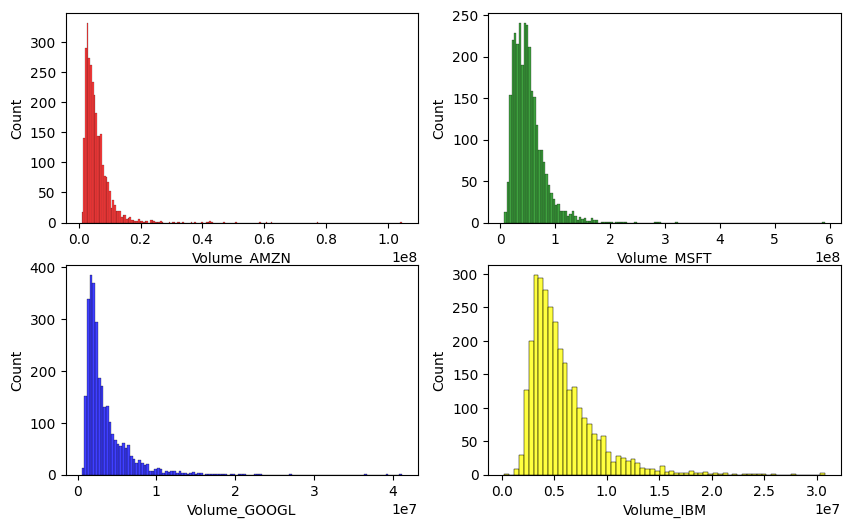

In [6]:
# Frequency distribution of volumes
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
sns.histplot(AG["Volume_AMZN"],color="red",ax=axes[0,0])
sns.histplot(AG["Volume_MSFT"],color="green",ax=axes[0,1])
sns.histplot(AG["Volume_GOOGL"],color="blue",ax=axes[1,0])
sns.histplot(AG["Volume_IBM"],color="yellow",ax=axes[1,1])
plt.show()


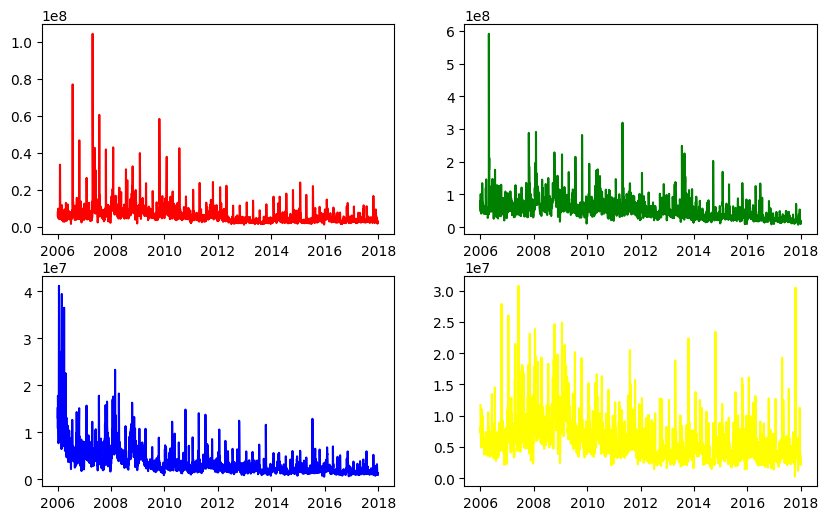

In [7]:
# Stock volume variation over time
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
axes[0,0].plot(AG["Volume_AMZN"],color="red")
axes[0,1].plot(AG["Volume_MSFT"],color="green")
axes[1,0].plot(AG["Volume_GOOGL"],color="blue")
axes[1,1].plot(AG["Volume_IBM"],color="yellow")
plt.show()


#### **1.2.2** <font color =red> [3 marks] </font>
Analyse correlations between features.

<Axes: >

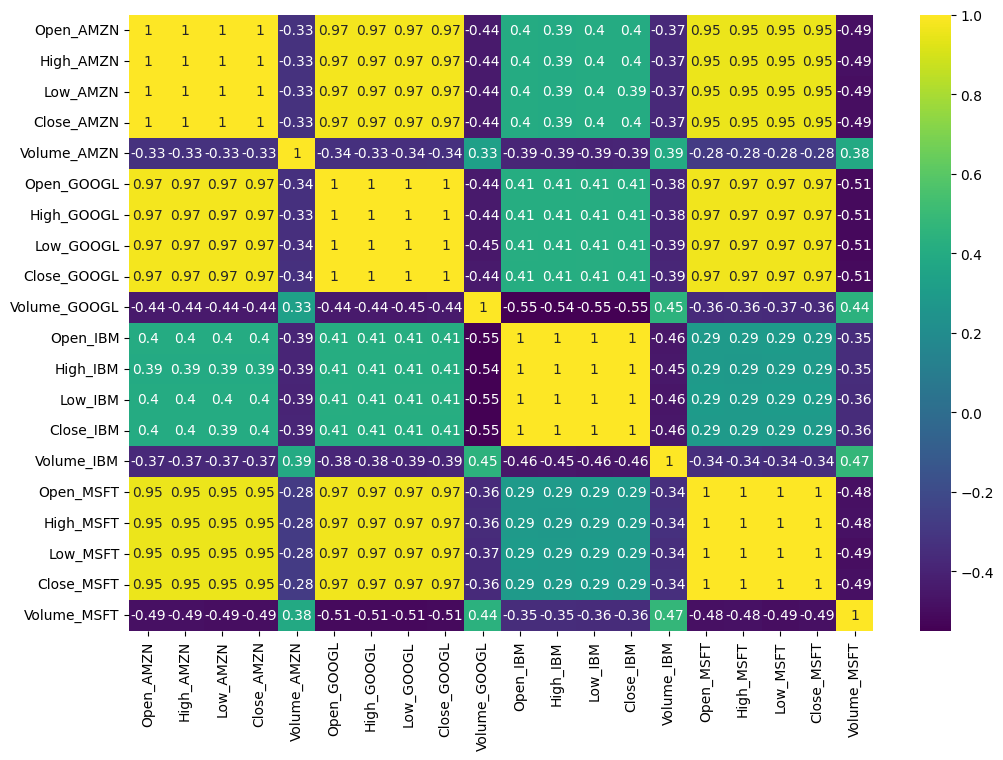

In [8]:
# Analyse correlations
plt.figure(figsize=(12,8))
sns.heatmap(AG.select_dtypes(include=["int","float"]).corr(),annot=True,cmap="viridis")

### **1.3 Data Processing** <font color =red> [13 marks] </font>

Next, we need to process the data so that it is ready to be used in recurrent neural networks. You know RNNs are suitable to work with sequential data where patterns repeat at regular intervals.

For this, we need to execute the following steps:
1. Create windows from the master data frame and obtain windowed `X` and corresponding windowed `y` values
2. Perform train-test split on the windowed data
3. Scale the data sets in an appropriate manner

We will define functions for the above steps that finally return training and testing data sets that are ready to be used in recurrent neural networks.

**Hint:** If we use a window of size 3, in the first window, the rows `[0, 1, 2]` will be present and will be used to predict the value of `CloseAMZN` in row `3`. In the second window, rows `[1, 2, 3]` will be used to predict `CloseAMZN` in row `4`.

#### **1.3.1** <font color =red> [3 marks] </font>
Create a function that returns the windowed `X` and `y` data.

From the main DataFrame, this function will create windowed DataFrames, and store those as a list of DataFrames.

Controllable parameters will be window size, step size (window stride length) and target names as a list of the names of stocks whose closing values we wish to predict.

In [9]:
# Define a function that divides the data into windows and generates target variable values for each window
def create_window_data(data,window_size):
    X=[]
    y=[]
    for i in range(window_size,len(data)):
        X.append(data.iloc[i-window_size:i].values)
        y.append(data.iloc[i].values)
    return np.array(X),np.array(y)   

#### **1.3.2** <font color =red> [3 marks] </font>
Create a function to scale the data.

Define a function that will scale the data.

For scaling, we have to look at the whole length of data to find max/min values or standard deviations and means. If we scale the whole data at once, this will lead to data leakage in the windows. This is not necessarily a problem if the model is trained on the complete data with cross-validation.

One way to scale when dealing with windowed data is to use the `partial_fit()` method.
```
scaler.partial_fit(window)
scaler.transform(window)
```
You may use any other suitable way to scale the data properly. Arrive at a reasonable way to scale your data.

In [10]:
# Define a function that scales the windowed data
# The function takes in the windowed data sets and returns the scaled windows
def scale_windowed_data(windows,target, feature_range=(0, 1)):

    scaler = MinMaxScaler(feature_range=feature_range)

  
    num_samples, window_size, num_features = windows.shape
    windows_reshaped = windows.reshape(-1, num_features)  


    scaled_windows_reshaped = scaler.fit_transform(windows_reshaped)

    scaled_windows = scaled_windows_reshaped.reshape(num_samples, window_size, num_features)
    scaled_target=scaler.transform(target)
    return scaled_windows,scaled_target, scaler


In [11]:
def create_train_test_split(left,right):
    X_train,X_test,y_train,y_test = train_test_split(left,right,train_size=0.8,random_state=42)
    return X_train,X_test,y_train,y_test 

Next, define the main function that will call the windowing and scaling helper functions.

The input parameters for this function are:
- The joined master data set
- The names of the stocks that we wish to predict the *Close* prices for
- The window size
- The window stride
- The train-test split ratio

The outputs from this function are the scaled dataframes:
- *X_train*
- *y_train*
- *X_test*
- *y_test*

#### **1.3.3** <font color =red> [3 marks] </font>
Define a function to create windows of `window_size` and split the windowed data in to training and validation sets.

The function can take arguments such as list of target names, window size, window stride and split ratio. Use the windowing function here to make windows in the data and then perform scaling and train-test split.

In [12]:
# Define a function to create input and output data points from the master DataFrame



We can now use these helper functions to create our training and testing data sets. But first we need to decide on a length of windows. As we are doing time series prediction, we want to pick a sequence that shows some repetition of patterns.

For selecting a good sequence length, some business understanding will help us. In financial scenarios, we can either work with business days, weeks (which comprise of 5 working days), months, or quarters (comprising of 13 business weeks). Try looking for some patterns for these periods.

#### **1.3.4** <font color =red> [2 marks] </font>
Identify an appropriate window size.

For this, you can use plots to see how target variable is varying with time. Try dividing it into parts by weeks/months/quarters.

In [13]:
# Checking for patterns in different sequence lengths
def visualize_target_trend(data, target_column, freq='M'):
    aggregated_data = data[target_column].resample(freq).mean()
    
    
    plt.figure(figsize=(7, 3))
    plt.plot(data[target_column], label='Original Data', alpha=0.5)
    
    
    plt.plot(aggregated_data, label=f'Aggregated Data ({freq})', linewidth=2)
    plt.title('Target Variable Trend')
    plt.xlabel('Time')
    plt.ylabel('Target')
    plt.legend()
    plt.grid()
    plt.show()


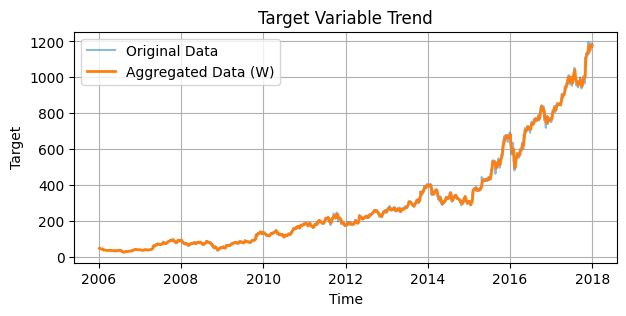

In [14]:
data=AG
target_column="Close_AMZN"
freq="W"
visualize_target_trend(data,target_column,freq)

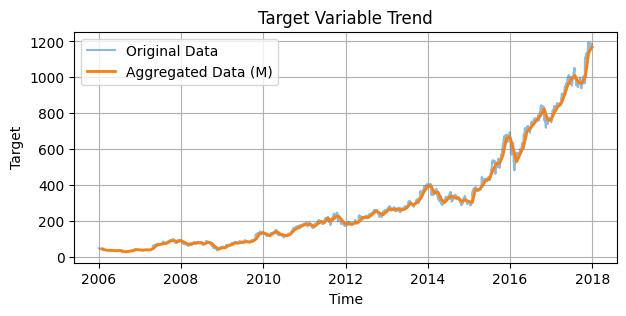

In [15]:
data=AG
target_column="Close_AMZN"
freq="M"
visualize_target_trend(data,target_column,freq)

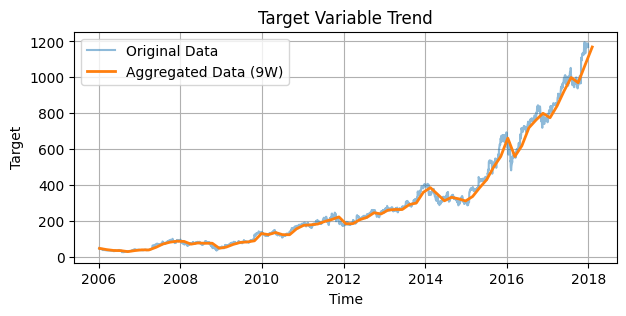

In [16]:
data=AG
target_column="Close_AMZN"
freq="9W"
visualize_target_trend(data,target_column,freq)

In [17]:
# it seem if we go for window size 7 it will be overfit 
# the best window seems to be 9W which is 63 so taking approximate 
## we can take window size as 60 ##

#### **1.3.5** <font color =red> [2 marks] </font>
Call the functions to create testing and training instances of predictor and target features.

In [18]:
# Create data instances from the master data frame using decided window size and window stride

X,y=create_window_data(AG,60)

In [19]:
# Check the number of data points generated
X.shape,y.shape

((2958, 60, 20), (2958, 20))

In [20]:
X_scaled,y_scaled ,scaler =scale_windowed_data(X,y, feature_range=(0, 1))

In [21]:
X_scaled.shape, y_scaled.shape

((2958, 60, 20), (2958, 20))

**Check if the training and testing datasets are in the proper format to feed into neural networks.**

In [22]:
# Check if the datasets are compatible inputs to neural networks

X_train,X_test,y_train,y_test= create_train_test_split(X_scaled,y_scaled)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((2366, 60, 20), (592, 60, 20), (2366, 20), (592, 20))

## **2 RNN Models** <font color =red> [20 marks] </font>

In this section, we will:
- Define a function that creates a simple RNN
- Tune the RNN for different hyperparameter values
- View the performance of the optimal model on the test data

### **2.1 Simple RNN Model** <font color =red> [10 marks] </font>

#### **2.1.1** <font color =red> [3 marks] </font>
Create a function that builds a simple RNN model based on the layer configuration provided.

In [23]:
# Create a function that creates a simple RNN model according to the model configuration arguments
def create_rnn_model(input_shape, dense_units=20,rnn_units=64, activation='relu', output_activation='linear', optimizer=Adam(learning_rate=0.0001), loss="mse"):
    
    model = Sequential()
    
    model.add(SimpleRNN(units=rnn_units, activation=activation, input_shape=input_shape, return_sequences=True))
    model.add(SimpleRNN(units=rnn_units, activation=activation, input_shape=input_shape, return_sequences=False))
    model.add(Dropout(0.5))

    
    model.add(Dense(units=dense_units, activation=output_activation))
    
    model.compile(optimizer=optimizer, loss=loss,metrics=['mean_squared_error'])
    return model


#### **2.1.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [24]:
def simple_rnn_tune_model(input_shape):
    def build_model(hp):
        model = Sequential()
        model.add(SimpleRNN(hp.Int('units', min_value=32, max_value=64, step=32), activation='relu', input_shape=input_shape, return_sequences=True))
        model.add(SimpleRNN(hp.Int('units', min_value=32, max_value=64, step=32), activation='relu', return_sequences=False))
        model.add(Dropout(hp.Float('dropout', min_value=0.3, max_value=0.5, step=0.1)))
        model.add(Dense(1, activation='linear'))
        model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[0.01,0.001,0.0001])), loss='mse', metrics=['mean_squared_error'])
        return model

    tuner = RandomSearch(build_model, objective='val_loss', max_trials=4, directory='simple_rnn_stock_price', project_name='rnn_tuning')
    return tuner

In [25]:
# Find an optimal configuration of simple RNN
simple_rnn_fine_tune=simple_rnn_tune_model(input_shape=(60,20))

Reloading Tuner from simple_rnn_stock_price\rnn_tuning\tuner0.json


In [26]:
simple_rnn_fine_tune.search(X_train, y_train,epochs=20,  batch_size=32,validation_split=0.2)

In [27]:
simple_rnn_best = simple_rnn_fine_tune.get_best_hyperparameters(num_trials=4)[0]

print(f"""
The optimal number of units in the simple_rnn layer is {simple_rnn_best.get('units')}.
The optimal dropout rate is {simple_rnn_best.get('dropout')}.
The optimal learning rate is {simple_rnn_best.get('learning_rate')}.
""")


The optimal number of units in the simple_rnn layer is 64.
The optimal dropout rate is 0.5.
The optimal learning rate is 0.01.



In [28]:
model=create_rnn_model((60,20),dense_units=20,rnn_units=64, activation='relu', output_activation='linear', optimizer=Adam(learning_rate=0.01), loss="mse")


In [72]:
# Find the best configuration based on evaluation metrics

In [30]:
early_stopping = EarlyStopping(monitor='val_mean_squared_error', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_mean_squared_error')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 60, 64)              │           5,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 20)                  │           1,300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,996 (58.58 KB)

 Trainable params: 14,996 (58.58 KB)

 Non-trainable params: 0 (0.00 B)

#### **2.1.3** <font color =red> [3 marks] </font>
Run for optimal Simple RNN Model and show final results.

In [31]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the model
history=model.fit(X_train,y_train,validation_split=0.2,batch_size=32,epochs=40,verbose=1,callbacks=[early_stopping,checkpoint])

Epoch 1/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0743 - mean_squared_error: 0.0743 - val_loss: 0.0058 - val_mean_squared_error: 0.0058
Epoch 2/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0139 - mean_squared_error: 0.0139 - val_loss: 0.0108 - val_mean_squared_error: 0.0108
Epoch 3/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0142 - mean_squared_error: 0.0142 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 4/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 5/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0108 - mean_squared_error: 0.0108 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 6/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 7/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0029 - va

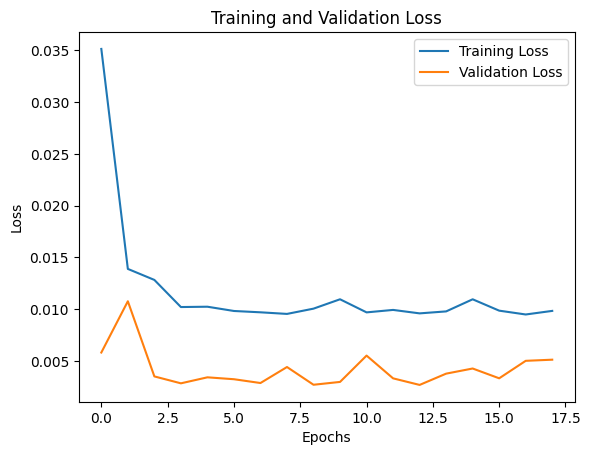

In [32]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [33]:
prediction=model.predict(X_train)

74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [34]:
predictor=scaler.inverse_transform(prediction)

In [35]:
y_train_actual =scaler.inverse_transform(y_train)

In [36]:
predictor.shape,y_train_actual.shape

((2366, 20), (2366, 20))

In [37]:
y_train_actual_frame=pd.DataFrame(y_train_actual ,columns=AG.columns,index=AG[:2366].index)
predictor_frame=pd.DataFrame(predictor ,columns=AG.columns,index=AG[:2366].index)

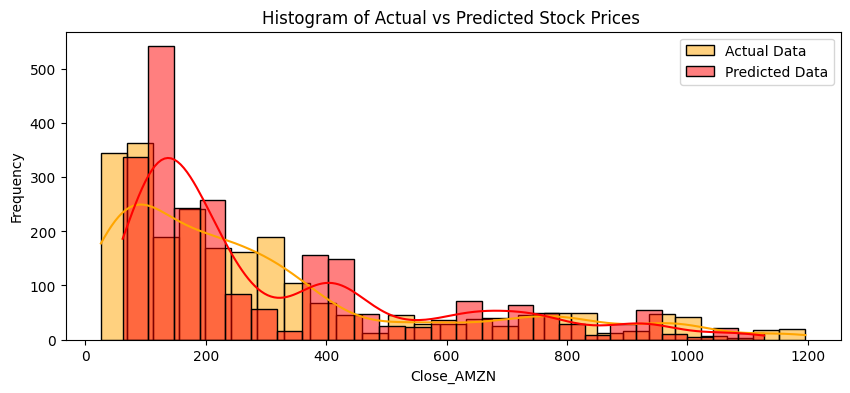

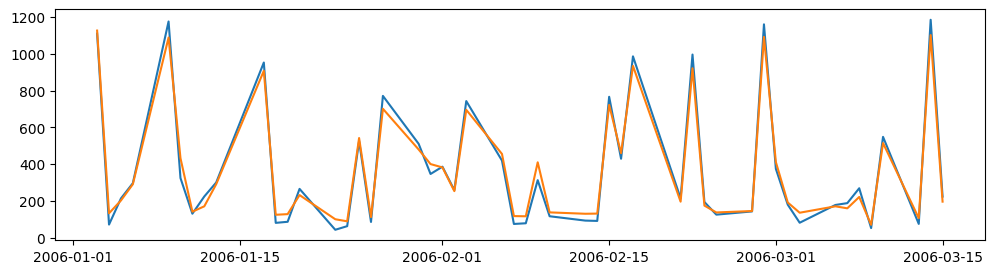

In [38]:
plt.figure(figsize=(10, 4))
column="Close_AMZN"
sns.histplot(y_train_actual_frame[column], color="orange", label="Actual Data", kde=True, alpha=0.5)
sns.histplot(predictor_frame[column], color="red", label="Predicted Data", kde=True, alpha=0.5)

plt.xlabel(column)
plt.ylabel("Frequency")
plt.title("Histogram of Actual vs Predicted Stock Prices ")
plt.legend()


plt.figure(figsize=(12, 3))
column="Close_AMZN"
plt.plot(y_train_actual_frame.index[:50], y_train_actual_frame[column][:50], label='Data')
plt.plot(predictor_frame.index[:50], predictor_frame[column][:50], label='Data')

In [39]:
column="Close_AMZN"
mse = mean_squared_error(y_train_actual_frame[column], predictor_frame[column])
print("Mean Squared Error:", mse)

# Mean Absolute Error
mae = mean_absolute_error(y_train_actual_frame[column], predictor_frame[column])
print("Mean Absolute Error:", mae)

# Root Mean Squared Error
rmse = mse ** 0.5
print("Root Mean Squared Error:", rmse)

Mean Squared Error: 2060.61685614967
Mean Absolute Error: 37.59404361379822
Root Mean Squared Error: 45.39401784541296


In [40]:
y_test.shape

(592, 20)

In [41]:
X_test.shape

(592, 60, 20)

Plotting the actual vs predicted values

In [42]:
# Predict on the test data and plot
prediction2=model.predict(X_test)
predictor2=scaler.inverse_transform(prediction2)
y_test_actual =scaler.inverse_transform(y_test)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [43]:
y_test_actual_frame=pd.DataFrame(y_test_actual ,columns=AG.columns,index=AG[2366:2958].index)
predictor2_frame=pd.DataFrame(predictor2 ,columns=AG.columns,index=AG[2366:2958].index)

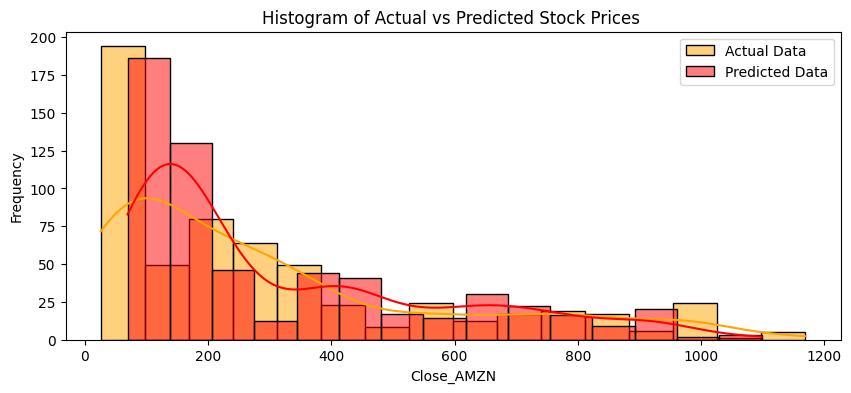

In [44]:
plt.figure(figsize=(10, 4))
column="Close_AMZN"
sns.histplot(y_test_actual_frame[column], color="orange", label="Actual Data", kde=True, alpha=0.5)
sns.histplot(predictor2_frame[column], color="red", label="Predicted Data", kde=True, alpha=0.5)

plt.xlabel(column)
plt.ylabel("Frequency")
plt.title("Histogram of Actual vs Predicted Stock Prices ")
plt.legend()

It is worth noting that every training session for a neural network is unique. So, the results may vary slightly each time you retrain the model.

In [45]:
# Compute the performance of the model on the testing data set
from sklearn.metrics import mean_squared_error,mean_absolute_error
column="Close_AMZN"
mse = mean_squared_error(y_test_actual_frame[column], predictor2_frame[column])
print("Mean Squared Error:", mse)

# Mean Absolute Error
mae = mean_absolute_error(y_test_actual_frame[column], predictor2_frame[column])
print("Mean Absolute Error:", mae)

# Root Mean Squared Error
rmse = mse ** 0.5
print("Root Mean Squared Error:", rmse)



Mean Squared Error: 2140.7373292528664
Mean Absolute Error: 38.79919695261363
Root Mean Squared Error: 46.2681027193991


### **2.2 Advanced RNN Models** <font color =red> [10 marks] </font>

In this section, we will:
- Create an LSTM or a GRU network
- Tune the network for different hyperparameter values
- View the performance of the optimal model on the test data

#### **2.2.1** <font color =red> [3 marks] </font>
Create a function that builds an advanced RNN model with tunable hyperparameters.

In [46]:
# # Define a function to create a model and specify default values for hyperparameters
def tune_model(input_shape):
    def build_model(hp):
        model = Sequential()
        model.add(LSTM(hp.Int('units', min_value=32, max_value=64, step=32), activation='relu', input_shape=input_shape, return_sequences=True))
        model.add(LSTM(hp.Int('units', min_value=32, max_value=64, step=32), activation='relu', return_sequences=False))
        model.add(Dropout(hp.Float('dropout', min_value=0.3, max_value=0.5, step=0.1)))
        model.add(Dense(1, activation='linear'))
        model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[0.01,0.001,0.0001])), loss='mse', metrics=['mean_squared_error'])
        return model

    tuner = RandomSearch(build_model, objective='val_loss', max_trials=4, directory='rnn_stock_price', project_name='rnn_tuning')
    return tuner

In [47]:
fine_tune=tune_model(input_shape=(60,20))

Reloading Tuner from rnn_stock_price\rnn_tuning\tuner0.json


#### **2.2.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [48]:
# Find an optimal configuration
fine_tune.search(X_train, y_train,epochs=20,  batch_size=32,validation_split=0.2)

#### **2.2.3** <font color =red> [3 marks] </font>
Run for optimal RNN Model and show final results.

In [49]:
# Create the model with a combination of potentially optimal hyperparameter values and retrain the model

best = fine_tune.get_best_hyperparameters(num_trials=3)[0]

print(f"""
The optimal number of units in the LSTM layer is {best.get('units')}.
The optimal dropout rate is {best.get('dropout')}.
The optimal learning rate is {best.get('learning_rate')}.
""")


The optimal number of units in the LSTM layer is 32.
The optimal dropout rate is 0.3.
The optimal learning rate is 0.001.



In [50]:
def create_LSTM_model(input_shape, dense_units=20,rnn_units=32, activation='relu', output_activation='linear', optimizer=Adam(learning_rate=0.001), loss="mse"):
    
    model = Sequential()
    
    model.add(LSTM(units=rnn_units, activation=activation, input_shape=input_shape, return_sequences=True))
    model.add(LSTM(units=rnn_units, activation=activation, input_shape=input_shape, return_sequences=False))
    model.add(Dropout(0.3))

    
    model.add(Dense(units=dense_units, activation=output_activation))
    
    model.compile(optimizer=optimizer, loss=loss,metrics=['mean_squared_error'])
    return model

In [51]:
LSTM_model=create_LSTM_model(input_shape=(60,20), dense_units=20,rnn_units=32, activation='relu', output_activation='linear', optimizer=Adam(learning_rate=0.001), loss="mse")

In [52]:
LSTM_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 32)              │           6,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 20)                  │             660 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,764 (61.58 KB)

 Trainable params: 15,764 (61.58 KB)

 Non-trainable params: 0 (0.00 B)

In [53]:
history2=LSTM_model.fit(X_train,y_train,validation_split=0.2,batch_size=32,epochs=40,verbose=1,callbacks=[early_stopping,checkpoint])

Epoch 1/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1092 - mean_squared_error: 0.1092 - val_loss: 0.0206 - val_mean_squared_error: 0.0206
Epoch 2/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0305 - mean_squared_error: 0.0305 - val_loss: 0.0068 - val_mean_squared_error: 0.0068
Epoch 3/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0189 - mean_squared_error: 0.0189 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 4/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0141 - mean_squared_error: 0.0141 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 5/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 6/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0097 - mean_squared_error: 0.0097 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 7/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0089 - mean_squared_error: 0.0089 - val_loss: 0.0021 - va

In [54]:
# Compute the performance of the model on the testing data set
LSTM_prediction2=LSTM_model.predict(X_test)
LSTM_predictor2=scaler.inverse_transform(LSTM_prediction2)
LSTM_y_test_actual =scaler.inverse_transform(y_test)

LSTM_y_test_actual_frame=pd.DataFrame(LSTM_y_test_actual ,columns=AG.columns,index=AG[2366:2958].index)
LSTM_predictor2_frame=pd.DataFrame(LSTM_predictor2 ,columns=AG.columns,index=AG[2366:2958].index)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Plotting the actual vs predicted values

In [55]:
# Predict on the test data
column="Close_AMZN"
mse = mean_squared_error(LSTM_y_test_actual_frame[column], LSTM_predictor2_frame[column])
print("Mean Squared Error:", mse)

# Mean Absolute Error
mae = mean_absolute_error(LSTM_y_test_actual_frame[column], LSTM_predictor2_frame[column])
print("Mean Absolute Error:", mae)

# Root Mean Squared Error
rmse = mse ** 0.5
print("Root Mean Squared Error:", rmse)

Mean Squared Error: 765.2460535064079
Mean Absolute Error: 21.79469443952715
Root Mean Squared Error: 27.66308105592014


## **3 Predicting Multiple Target Variables** <font color =red> [OPTIONAL] </font>

In this section, we will use recurrent neural networks to predict stock prices for more than one company.

### **3.1 Data Preparation**

#### **3.1.1**
Create testing and training instances for multiple target features.

You can take the closing price of all four companies to predict here.

In [56]:
# Create data instances from the master data frame using a window size of 65, a window stride of 5 and a test size of 20%
# Specify the list of stock names whose 'Close' values you wish to predict using the 'target_names' parameter



In [57]:
# Check the number of data points generated



### **3.2 Run RNN Models**

#### **3.2.1**
Perform hyperparameter tuning to find the optimal network configuration for Simple RNN model.

In [58]:
# Find an optimal configuration of simple RNN



In [59]:
# Find the best configuration



In [60]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the



In [61]:
# Compute the performance of the model on the testing data set



In [62]:
# Plotting the actual vs predicted values for all targets



#### **3.2.2**
Perform hyperparameter tuning to find the optimal network configuration for Advanced RNN model.

In [63]:
# Find an optimal configuration of advanced RNN



In [64]:
# Find the best configuration



In [65]:
# Create a model with a combination of potentially optimal hyperparameter values and retrain the model



In [66]:
# Compute the performance of the model on the testing data set



In [67]:
# Plotting the actual vs predicted values for all targets



## **4 Conclusion** <font color =red> [5 marks] </font>

### **4.1 Conclusion and insights** <font color =red> [5 marks] </font>

#### **4.1.1** <font color =red> [5 marks] </font>
Conclude with the insights drawn and final outcomes and results.

>-The lower MSE and RMSE indicate that LSTM handles the task  better by learning long-term dependencies in the input data.
>
>-The lower MAE demonstrates that LSTM also outperforms Simple RNN in reducing absolute prediction errors, suggesting better accuracy overall.

> -The optimal number of units in the LSTM layer is 32.
> 
> -The optimal dropout rate for LSTM is 0.3.
> 
> -The optimal learning rate for LSTM is 0.001.

> -The optimal number of units in the simple_rnn layer is 64.
>
> -The optimal dropout rate for simple rnn is 0.5.
>   
> -The optimal learning rate simple rnn is 0.01.

> -the optimal window is 60